## This notebook will load the precomputed dataframe containing FC values for all subjects, sessions, conditions, and ROI pairs. It will then perform a set of analyses to generate figures for the manuscript.

In [24]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import nibabel as nib
from nilearn import input_data, datasets, plotting
import os
import pickle

In [25]:
## Load the precomputed dataframe
path_to_df = '../data/precomputed/df_fc.pkl'
df = pd.read_pickle(path_to_df)

In [26]:
## Constants -- these are the same as in the notebook that generates the FC values
### constant means that we do not change these kitties
idx_pre = range(60,300) # we start at 60 instead of 0 because of some strange artifact at the beginning of the time series
idx_fus = range(300,600)
idx_post = range(600,900)

# the 1-based indices of the subgenual region in the DiFuMo atlas, where 0 is the background
idx_subgenual = 133
#idx_subgenual = np.random.randint(1,1024)

# load DiFuMo atlas
difumo = datasets.fetch_atlas_difumo(dimension=1024)
df_labels = pd.DataFrame(difumo.labels)  # List of 1024 anatomical labels
atlas_img = nib.load(difumo.maps)
subgenual = df_labels.loc[idx_subgenual,'difumo_names']
print(subgenual)


Subgenual cortex


In [27]:
## filter df to only rows where either roi1 or roi2 is the subgenual region
df = df[(df.roi1 == subgenual) | (df.roi2 == subgenual)]
df.shape

(98208, 6)

In [28]:
## Add a column to the dataframe that contains the connection of the subgenual region to the connected region
df["connection"] = df.apply(lambda x: x['roi1'] if x['roi2'] == subgenual else x['roi2'], axis=1)

In [29]:
dfg_mu = df.groupby(['condition','time_window','connection'])['fc'].mean()
dfg_std = df.groupby(['condition','time_window','connection'])['fc'].std()

In [30]:
# convert dfg_mean so that the indices are columns
dfg = dfg_mu.reset_index()
dfg["mean"] = dfg_mu.values
dfg["std"] = dfg_std.values
dfg.drop(columns = 'fc', inplace = True)

In [31]:
## create a new dataframe where the time_window is a separate column
dfg2 = dfg.pivot_table(index = ['condition','connection'], columns = 'time_window', values = ['mean','std']).reset_index()

In [32]:
# convert dfg2 to a single level index
dfg2.columns = ['_'.join(col).strip() for col in dfg2.columns.values]
dfg2['condition_'] = dfg2['condition_'].astype(str)
dfg2['connection_'] = dfg2['connection_'].astype(str)

In [33]:
dfg2["del_fus"] = dfg2["mean_fus"] - dfg2["mean_pre"]
dfg2["del_post"] = dfg2["mean_post"] - dfg2["mean_pre"]
dfg2["del_pct_change_fus"] = dfg2["del_fus"] / dfg2["std_pre"]
dfg2["del_pct_change_post"] = dfg2["del_post"] / dfg2["std_pre"]
#dfg2["del_pct_change_fus"] = dfg2["del_fus"] / dfg2["mean_pre"].abs()
#dfg2["del_pct_change_post"] = dfg2["del_post"] / dfg2["mean_pre"].abs()

In [34]:
dfg2.groupby('condition_')[['mean_pre','mean_fus','mean_post','del_fus','del_post','del_pct_change_fus','del_pct_change_post']].mean()

,mean_pre,mean_fus,mean_post,del_fus,del_post,del_pct_change_fus,del_pct_change_post
condition_,,,,,,,
active,0.061365,0.100091,0.127845,0.038726,0.066480,0.218605,0.380771
sham,0.121108,0.101353,0.109771,-0.019754,-0.011337,-0.100800,-0.052728


In [35]:
#dfg2.sort_values('del_fus',ascending=False)

## create a new dataframe where the index is the connection and the columns are: del_fus_active, del_post_active, del_fus_sham, del_post_sham, mean_pre_active, mean_pre_sham
dfg3 = dfg2.pivot_table(index = 'connection_', columns = 'condition_', values = ['del_fus','del_post','mean_pre', 'mean_fus', 'mean_post']).reset_index()
dfg3.columns = ['_'.join(col).strip() for col in dfg3.columns.values]


In [36]:
dfg3

,connection__,del_fus_active,del_fus_sham,del_post_active,del_post_sham,mean_fus_active,mean_fus_sham,mean_post_active,mean_post_sham,mean_pre_active,mean_pre_sham
0,Amygdala anterior,0.002007,0.013971,0.069775,0.034126,0.187152,0.231049,0.254920,0.251204,0.185146,0.217078
1,Amygdala posterior,0.005076,0.032778,-0.027493,0.065765,0.128568,0.118131,0.096000,0.151118,0.123493,0.085353
2,Angular gyrus anterior LH,-0.022773,0.005313,-0.001271,-0.005003,0.106052,0.140325,0.127554,0.130009,0.128824,0.135012
3,Angular gyrus antero-inferior LH,0.030423,-0.028136,0.093997,-0.052981,0.105668,0.159494,0.169242,0.134649,0.075244,0.187630
4,Angular gyrus antero-superior LH,0.078080,-0.115851,0.088599,-0.039411,0.114713,0.024364,0.125232,0.100804,0.036633,0.140215
...,...,...,...,...,...,...,...,...,...,...,...
977,Ventromedial prefrontal cortex anterior,0.002694,0.015498,0.069114,0.022692,0.351058,0.387526,0.417477,0.394720,0.348364,0.372028
978,Ventromedial prefrontal cortex anterior LH,0.059491,-0.052806,0.085674,-0.005362,0.308132,0.309796,0.334315,0.357240,0.248641,0.362602
979,Ventromedial prefrontal cortex antero-inferior,-0.002850,-0.044020,0.021538,-0.055472,0.307256,0.358315,0.331644,0.346863,0.310106,0.402335
980,Ventromedial prefrontal cortex posterior,-0.021542,0.025034,0.011600,0.064626,0.019080,0.075511,0.052222,0.115103,0.040622,0.050478


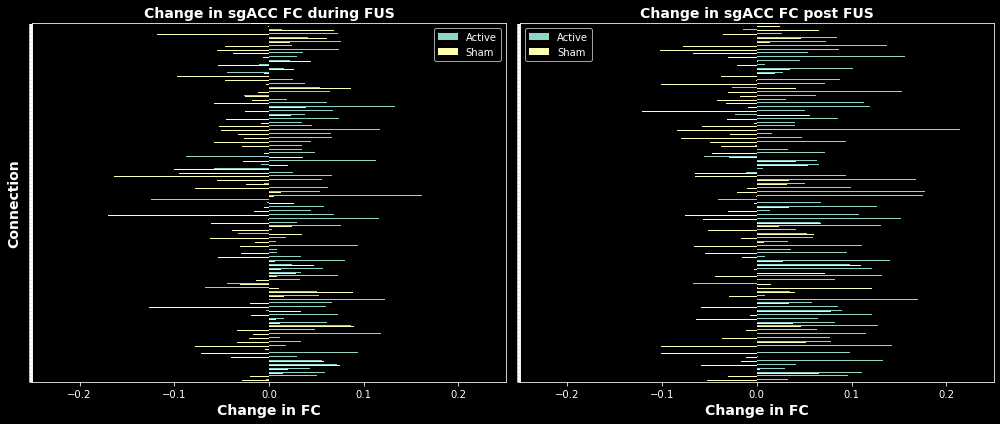

In [37]:
plt.style.use('dark_background')
fig, ax = plt.subplots(1,2,figsize=(14,6))
fontdict = {'fontsize': 14, 'fontweight': 'bold'}

# create horizontal bar plot with no tick labels on the y-axis
dfg3.plot(x = 'connection__', y = ['del_fus_active','del_fus_sham'], kind = 'barh', ax = ax[0])
ax[0].set_xlabel('Change in FC', fontdict = fontdict)
ax[0].set_yticklabels([])
ax[0].set_ylabel('Connection', fontdict = fontdict)
ax[0].set_title('Change in sgACC FC during FUS', fontdict = fontdict)
ax[0].set_xlim(-0.25,0.25)
ax[0].legend(['Active','Sham'])
dfg3.plot(x = 'connection__', y = ['del_post_active','del_post_sham'], kind = 'barh', ax = ax[1])
ax[1].set_xlabel('Change in FC', fontdict = fontdict)
ax[1].set_yticklabels([])
ax[1].set_ylabel('')
ax[1].set_title('Change in sgACC FC post FUS', fontdict = fontdict)
ax[1].set_xlim(-0.25,0.25)
ax[1].legend(['Active','Sham'])

fig.tight_layout()
fig.savefig('../figures/sgACC_fc_change.png', dpi=300)

## Visualize FC changes as a network graph

In [40]:
# Load DiFuMo atlas
#roi_coordinates = plotting.find_probabilistic_atlas_cut_coords(difumo.maps)  # Anatomical coordinates of ROIs

In [41]:
#roi_labels = difumo.labels
#roi_labels = [x[1] for x in roi_labels]

In [42]:
# get the coordinates of each ROI in the difumo atlas
#roi_to_coords = {label: coord for label, coord in zip(roi_labels, roi_coordinates)}

In [43]:
# Example: Top connections DataFrame (replace this with your actual data)
#data = [
#    ["sgACC", "Paracingulate sulcus middle LH", 0.173897],
#    ["sgACC", "Middle temporal gyrus middle RH", 0.172191],
#    ["sgACC", "Lingual gyrus anterior RH", 0.168216],
#    ["sgACC", "Anterior orbital gyrus RH", 0.164764],
#    ["sgACC", "Parieto-occipital sulcus mid-anterior LH", 0.162196],
#]
#columns = ["seed", "target", "del_fus"]
#df = pd.DataFrame(data, columns=columns)


In [44]:
# Get coordinates for seed and target ROIs
#df["seed_coords"] = df["seed"].apply(lambda x: roi_to_coords.get(x, (np.nan, np.nan, np.nan)))
#df["target_coords"] = df["target"].apply(lambda x: roi_to_coords.get(x, (np.nan, np.nan, np.nan)))

# Filter out invalid coordinates
#df = df.dropna(subset=["seed_coords", "target_coords"])

# Extract connectivity data for plotting
#connectivity_matrix = np.zeros((len(df), len(df)))
#for idx, row in df.iterrows():
#    seed_idx = idx
#    target_idx = idx
#    connectivity_matrix[seed_idx, target_idx] = row["del_fus"]

# Extract coordinates
#node_coords = np.array([row["target_coords"] for _, row in df.iterrows()])

# Plot the connectome
#plotting.plot_connectome(
#    adjacency_matrix=connectivity_matrix,
#    node_coords=node_coords,
#)
#view.open_in_browser()  # Opens the interactive visualization in your browser

In [45]:
#connectivity_matrix

In [46]:

# Keywords for DMN and affective networks
#dmn_keywords = ["medial prefrontal", "posterior cingulate", "parahippocampal", "hippocampus"]
#affective_keywords = ["amygdala", "insula", "orbitofrontal", "ventral striatum", "thalamus"]

# Filter for relevant regions
#dmn_regions = df_labels[df_labels["Label"].str.contains("|".join(dmn_keywords), case=False, na=False)]
#affective_regions = df_labels[df_labels["Label"].str.contains("|".join(affective_keywords), case=False, na=False)]

# Combine results
#relevant_regions = pd.concat([dmn_regions, affective_regions]).drop_duplicates()

# Save or print the relevant regions
#print("Regions in DMN and Affective Networks:")
#print(relevant_regions)

# Save to CSV (optional)
#relevant_regions.to_csv("dmn_affective_regions.csv", index=False)